Dataset Head:
   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null 

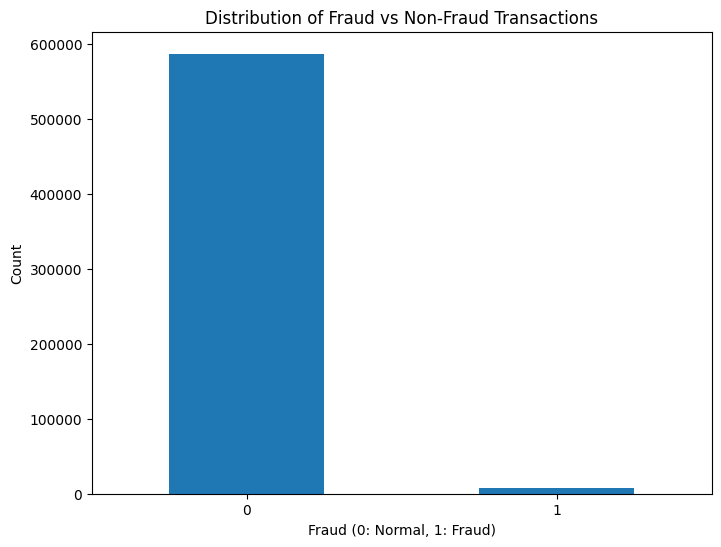

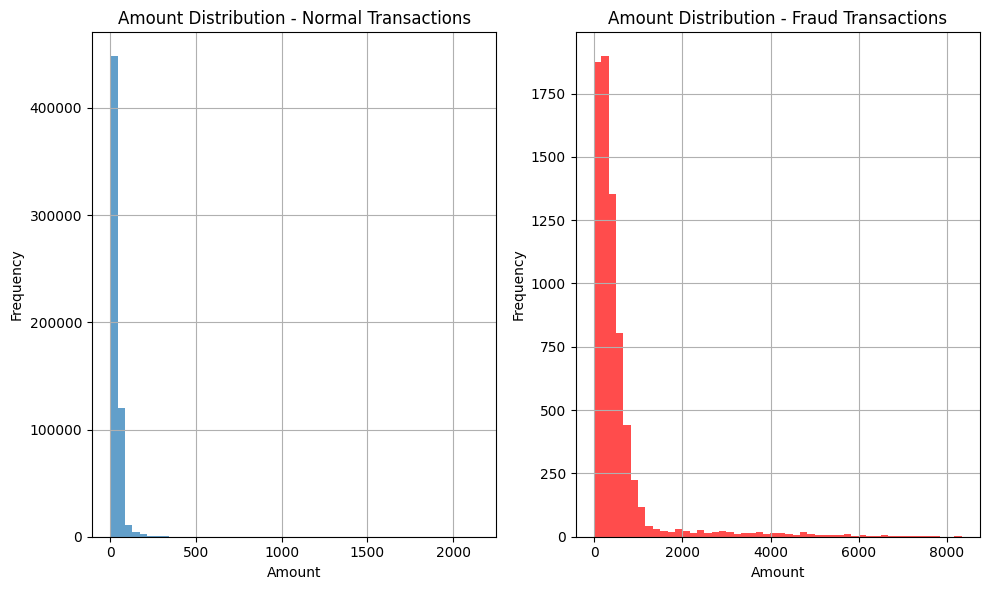

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/fraud.csv")

print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

print("\nFraud distribution:")
print(df["fraud"].value_counts())
print(df["fraud"].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 6))
df["fraud"].value_counts().plot(kind='bar')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('Fraud (0: Normal, 1: Fraud)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df[df['fraud'] == 0]['amount'].hist(bins=50, alpha=0.7, label='Normal')
plt.title('Amount Distribution - Normal Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df[df['fraud'] == 1]['amount'].hist(bins=50, alpha=0.7, label='Fraud', color='red')
plt.title('Amount Distribution - Fraud Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

df = pd.read_csv("/content/fraud.csv")

df["hour_of_day"] = df["step"] % 24

df = df.drop("step", axis=1)
df = df.drop(["customer", "zipcodeOri", "merchant", "zipMerchant"], axis=1)

categorical_features = ["age", "gender", "category"]
numerical_features = ["amount", "hour_of_day"]

X = df.drop("fraud", axis=1)
y = df["fraud"]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

X_processed = pipeline.fit_transform(X)

if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

print("Shape of processed features:", X_processed.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

print("Data preprocessing and feature engineering complete. Processed data saved to .npy files.")

Shape of processed features: (594643, 29)

Shape of X_train: (475714, 29)
Shape of X_test: (118929, 29)
Shape of y_train: (475714,)
Shape of y_test: (118929,)
Data preprocessing and feature engineering complete. Processed data saved to .npy files.


In [9]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import joblib
import numpy as np

X_train = np.load("X_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

print("Original y_train distribution:")
print(pd.Series(y_train).value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nResampled y_train distribution (SMOTE):")
print(pd.Series(y_train_res).value_counts())

print("\nTraining Logistic Regression Model...")
log_reg_model = LogisticRegression(solver="liblinear", random_state=42, class_weight="balanced")
log_reg_model.fit(X_train_res, y_train_res)

y_pred_log_reg = log_reg_model.predict(X_test)
y_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log_reg))
print("Logistic Regression F1-Score:", f1_score(y_test, y_pred_log_reg))

print("\nTraining Random Forest Model...")
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest AUC-ROC:", roc_auc_score(y_test, y_proba_rf))
print("Random Forest F1-Score:", f1_score(y_test, y_pred_rf))

joblib.dump(log_reg_model, "logistic_regression_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

print("\nModels trained and saved successfully.")

Original y_train distribution:
0    469954
1      5760
Name: count, dtype: int64

Resampled y_train distribution (SMOTE):
0    469954
1    469954
Name: count, dtype: int64

Training Logistic Regression Model...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97    117489
           1       0.16      0.98      0.27      1440

    accuracy                           0.94    118929
   macro avg       0.58      0.96      0.62    118929
weighted avg       0.99      0.94      0.96    118929

Logistic Regression AUC-ROC: 0.9922393503032435
Logistic Regression F1-Score: 0.26863117870722436

Training Random Forest Model...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    117489
           1       0.36      0.78      0.50      1440

    accuracy                           0.98    118929
   macro avg       0.68      0.